In [ ]:
%pip install numpy pandas matplotlib seaborn missingno importlib-metadata scikit-learn keras jinja2 feature_engine torch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import importlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import torch
import cudf

In [3]:
# Check GPU availability
print(f"CUDA supported: {torch.cuda.is_available()}")  # Should return True[2][5]

# Confirm CUDA version
print(f"PyTorch CUDA version: {torch.version.cuda}")  # e.g., 12.1[5]

# Check GPU details
print(f"Device count: {torch.cuda.device_count()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA supported: True
PyTorch CUDA version: 12.6
Device count: 1
Current device: 0
Device name: NVIDIA RTX A6000


In [4]:
# Init the Processor
import ORAN_Helper, Models

importlib.reload(ORAN_Helper)
processor = ORAN_Helper.Processor()
plotter = ORAN_Helper.Plotter(plt=plt,sns=sns)

def reload_all():
    global processor, plotter, models
    importlib.reload(ORAN_Helper)
    processor = ORAN_Helper.Processor()
    plotter = ORAN_Helper.Plotter(plt=plt,sns=sns)
    
    importlib.reload(Models)

2025-05-07 14:18:21.920933: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 14:18:21.931960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746607701.945300  215214 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746607701.949020  215214 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746607701.959068  215214 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [5]:
file_path_1 = "FBSDetector/dataset/msa_nas.csv"
file_path_2=  "FBSDetector/dataset/msa_nas_reshaped.csv"
file_path_3 = "FBSDetector/dataset/msa_rrc.csv"
file_path_4=  "FBSDetector/dataset/msa_rrc_reshaped.csv"

In [6]:
msa_nas = pd.read_csv(file_path_1, index_col = 0)
msa_nas_reshaped = pd.read_csv(file_path_2, index_col = 0)
msa_rrc = pd.read_csv(file_path_3, index_col = 0)
msa_rrc_reshaped = pd.read_csv(file_path_4, index_col = 0)

print(f"msa_nas: {msa_nas.shape}")
print(f"msa_nas_reshaped: {msa_nas_reshaped.shape}")

print(f"msa_nas: {msa_rrc.shape}")
print(f"msa_nas_reshaped: {msa_rrc_reshaped.shape}")

msa_nas: (52758, 479)
msa_nas_reshaped: (17586, 479)
msa_nas: (1612, 856)
msa_nas_reshaped: (403, 856)


#### Checking for Infinite values

In [7]:
msa_nas.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS NAS: {msa_nas.isna().sum().sum()}")

msa_nas_reshaped.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS RRC: {msa_nas_reshaped.isna().sum().sum()}")

msa_rrc.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS NAS: {msa_nas.isna().sum().sum()}")

msa_rrc_reshaped.replace([np.inf, -np.inf], np.nan, inplace=True)
print(f"Number of Infinite values in FBS RRC: {msa_nas_reshaped.isna().sum().sum()}")

Number of Infinite values in FBS NAS: 0
Number of Infinite values in FBS RRC: 0
Number of Infinite values in FBS NAS: 0
Number of Infinite values in FBS RRC: 0


#### Checking for the Labels

### Lables are Attacker number from 0 to 21

##### Counting the number of each Label

In [8]:
mn = msa_nas['label'].value_counts()

print(f"MSA NAS \n {mn}")

mnr = msa_nas_reshaped['label'].value_counts()

print(f"\n\n MSA NAS Reshaped \n {mnr}")

mr = msa_rrc['label'].value_counts()

print(f"MSA NAS \n {mr}")

mrr = msa_rrc_reshaped['label'].value_counts()

print(f"\n\n MSA NAS Reshaped \n {mrr}")

MSA NAS 
 label
10    15346
2     15346
18    15346
0      3945
9       420
1       420
17      420
15      220
16      160
3       144
19      144
11      144
14      132
7       110
8        80
6        66
5        55
13       55
21       55
4        50
12       50
20       50
Name: count, dtype: int64


 MSA NAS Reshaped 
 label
2    15346
0     1315
1      420
3      144
7      110
8       80
6       66
5       55
4       50
Name: count, dtype: int64
MSA NAS 
 label
0     728
1     113
6     113
16    113
11    113
12     51
17     51
7      51
2      51
19     37
14     37
4      37
9      37
8      20
3      20
13     20
18     20
Name: count, dtype: int64


 MSA NAS Reshaped 
 label
0    182
1    113
2     51
4     37
3     20
Name: count, dtype: int64


#### Finding the correlation among the features

##### Separating data and labels

In [9]:
reload_all()
msa_nas_data, msa_nas_labels = processor.separate_label(msa_nas, label_name="label")
msa_nas_reshaped_data, msa_nas_reshaped_labels = processor.separate_label(msa_nas_reshaped, label_name="label")

msa_rrc_data, msa_rrc_labels = processor.separate_label(msa_rrc, label_name="label")
msa_rrc_reshaped_data, msa_rrc_reshaped_labels = processor.separate_label(msa_rrc_reshaped, label_name="label")

In [10]:
corr_matrix_msa_nas = msa_nas_data.corr().round(3)
corr_matrix_msa_nas_reshaped = msa_nas_reshaped_data.corr().round(3)

corr_matrix_msa_rrc = msa_rrc_data.corr().round(3)
corr_matrix_msa_rrc_reshaped = msa_rrc_reshaped_data.corr().round(3)

In [11]:
reload_all()
high_corr_pairs_msa_nas = processor.get_correlated_features(corr_matrix_msa_nas, Threshold=0.95, print_it=False)
high_corr_pairs_msa_nas_reshaped = processor.get_correlated_features(corr_matrix_msa_nas_reshaped, Threshold=0.95, print_it=False)

high_corr_pairs_msa_rrc = processor.get_correlated_features(corr_matrix_msa_rrc, Threshold=0.95, print_it=False)
high_corr_pairs_msa_rrc_reshaped = processor.get_correlated_features(corr_matrix_msa_rrc_reshaped, Threshold=0.95, print_it=False)

Number of Highly Co-related feature pairs: 2018 


Number of Highly Co-related feature pairs: 2018 


Number of Highly Co-related feature pairs: 50542 


Number of Highly Co-related feature pairs: 50542 




### Dropping really high correlated features

In [12]:
reload_all()

msa_nas_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_msa_nas, data=msa_nas_data)
msa_nas_reshaped_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_msa_nas_reshaped, data=msa_nas_reshaped_data)

msa_rrc_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_msa_rrc, data=msa_rrc_data)
msa_rrc_reshaped_data_processed = processor.drop_correlated_features(high_corr_pairs=high_corr_pairs_msa_rrc_reshaped, data=msa_rrc_reshaped_data)

Number of features to be dropped: 103
{'gsm_a_dtap_elem_id_unmaskedvalue', 'nested_field3_unmaskedvalue', 'nas-eps_emm_detach_req_ul_show', '_ws_expert_unmaskedvalue', 'nas-eps_emm_mme_grp_id_show', 'nas-eps_emm_tai_tac_size', 'nas-eps_emm_ebi4_size', 'nas-eps_emm_ebi4_unmaskedvalue', 'gsm_a_dtap_autn_show', 'gsm_a_L3_protocol_discriminator_size', 'nested_field2_value', 'nas-eps_emm_esm_msg_cont_unmaskedvalue', 'nas-eps_emm_imeisv_req_unmaskedvalue', 'nas-eps_security_header_type_size', 'nas-eps_emm_id_type2_size', 'nas-eps_emm_cause_unmaskedvalue', 'nas-eps_emm_ebi4_value', 'nas-eps_emm_nas_key_set_id_unmaskedvalue', 'nested_field6_size', 'nas-eps_emm_id_type2_show', '_unmaskedvalue', 'nas-eps_emm_eea3_show', 'nas-eps_emm_imeisv_req_show', 'nas-eps_emm_ebi7_show', 'gsm_a_dtap_coding_scheme_unmaskedvalue', 'gsm_a_len_size', 'nas-eps_emm_EPS_attach_result_show', 'nas-eps_emm_toi_unmaskedvalue', '_show', 'gsm_a_unused_size', 'nas-eps_emm_ebi11_size', 'nas-eps_emm_ebi9_size', 'gsm_a_dtap_

In [13]:
print(f"msa_nas: {msa_nas_data_processed.shape}")
print(f"msa_nas: {msa_nas_reshaped_data_processed.shape}")

print(f"msa_nas: {msa_rrc_data_processed.shape}")
print(f"msa_nas: {msa_rrc_reshaped_data_processed.shape}")

msa_nas: (52758, 375)
msa_nas: (17586, 375)
msa_nas: (1612, 74)
msa_nas: (403, 74)


#### Coutning for the number of unique values

MSA-NAS

Unique Value cout for:


/home/ashutosh/O-RADAR/ORAN_Helper.py:268: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


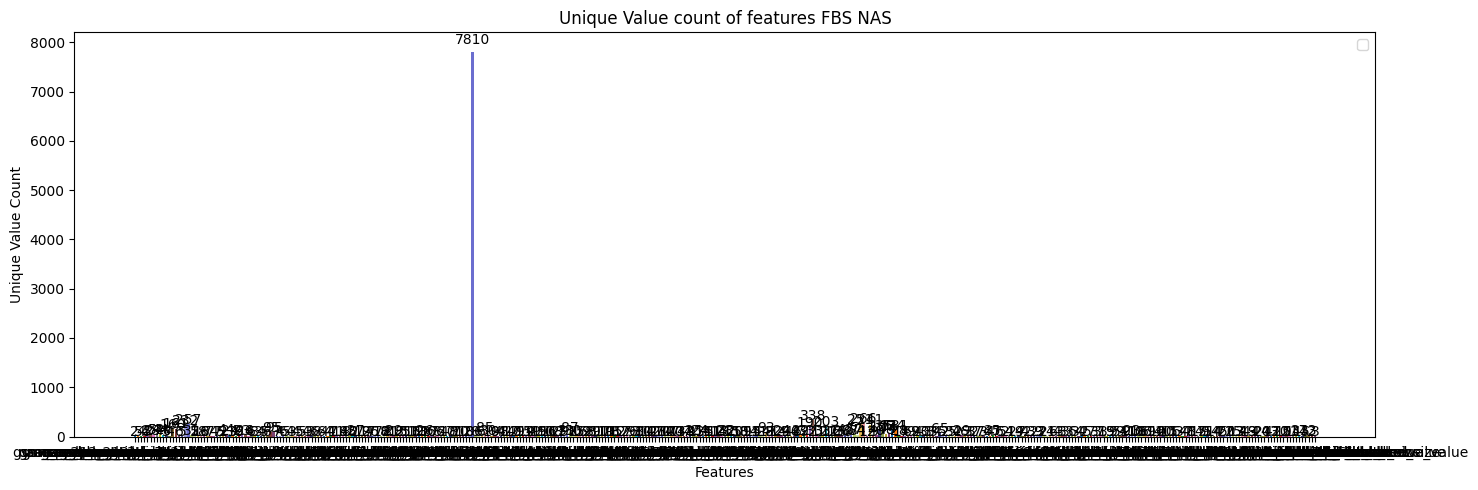

Unique Value cout for:


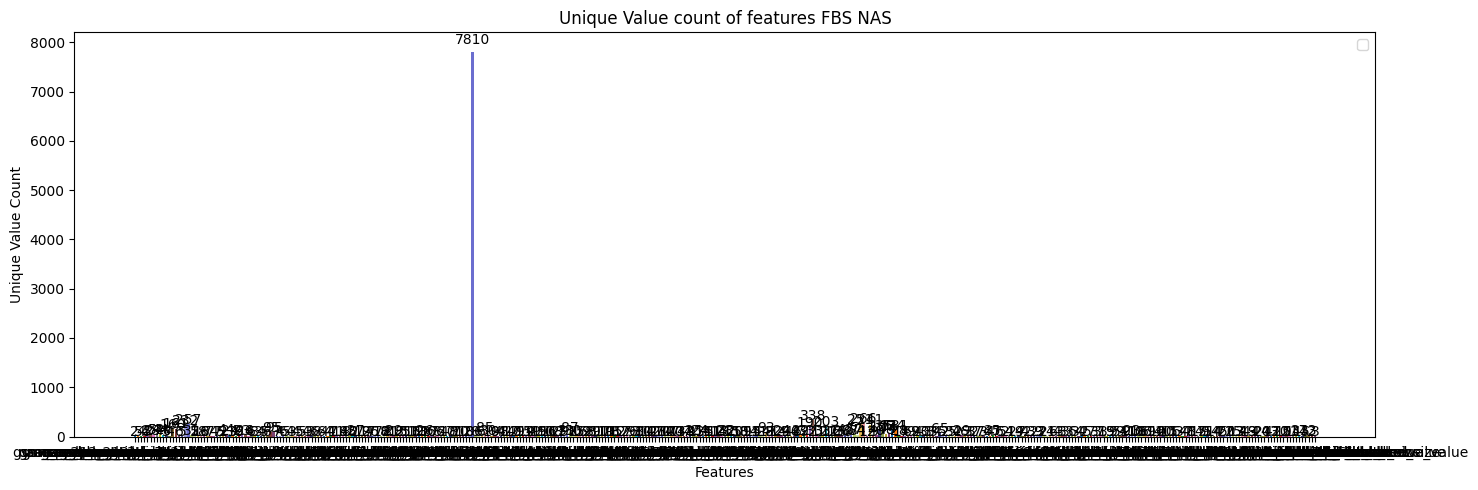

Unique Value cout for:


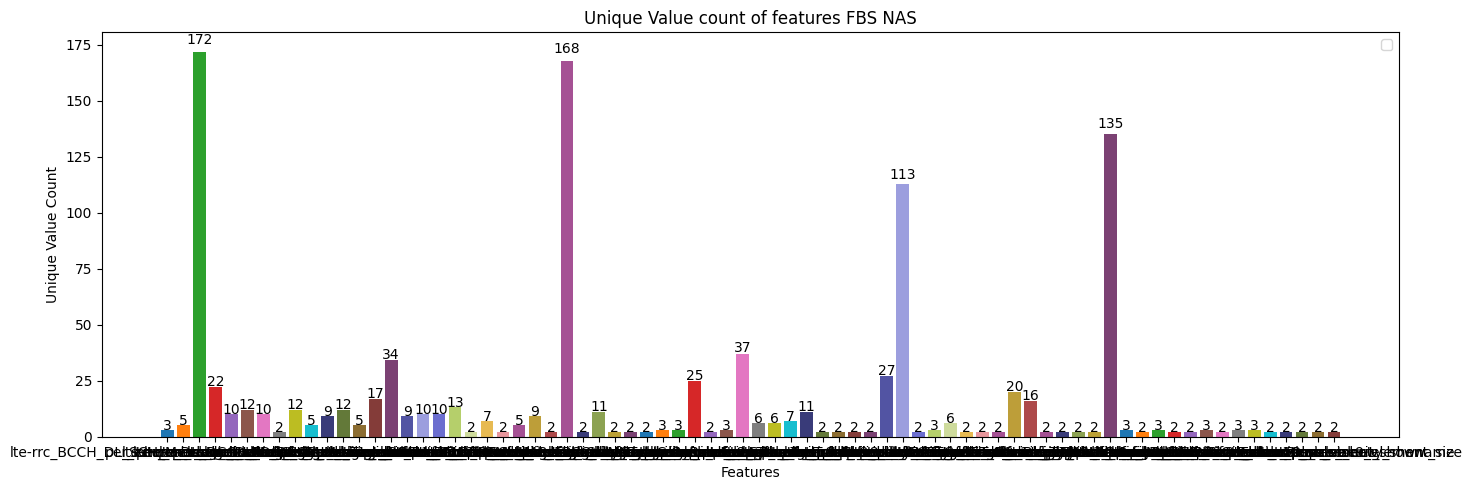

Unique Value cout for:


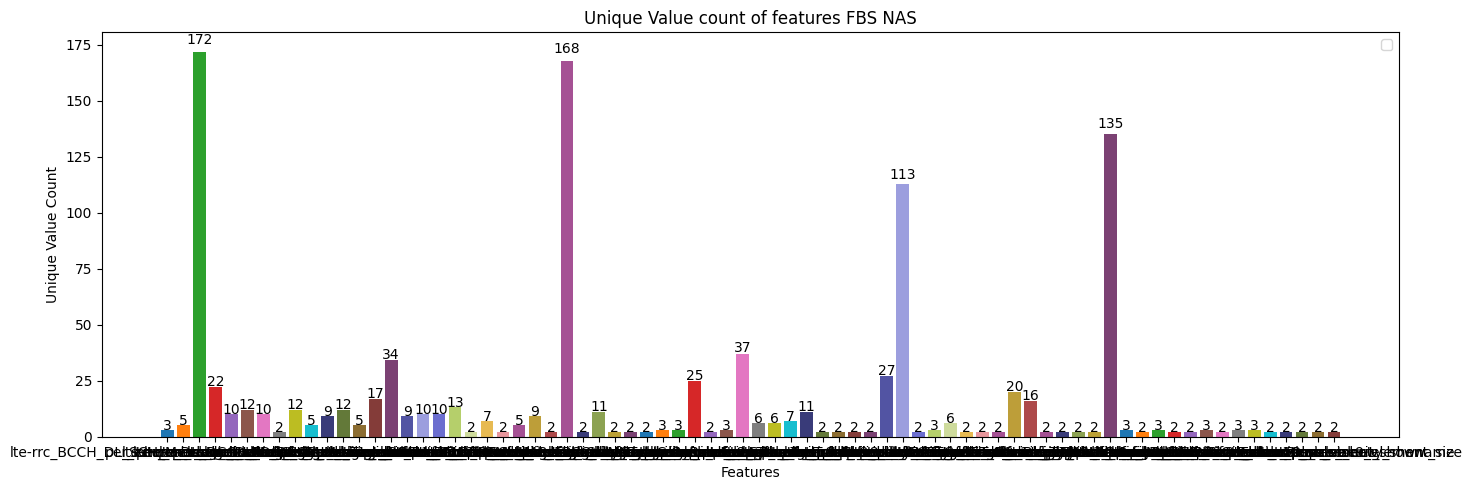

In [14]:
reload_all()
unique_dict_msa_nas = processor.get_unique_values_for_each_feature(data=msa_nas_data_processed, print_it = False)
plotter.plot_dict(unique_dict_msa_nas, fig_dimx=15, fig_dimy=5, title="Unique Value count of features FBS NAS", x_label="Features", y_label="Unique Value Count")

unique_dict_msa_nas_reshaped = processor.get_unique_values_for_each_feature(data=msa_nas_reshaped_data_processed, print_it = False)
plotter.plot_dict(unique_dict_msa_nas_reshaped, fig_dimx=15, fig_dimy=5, title="Unique Value count of features FBS NAS", x_label="Features", y_label="Unique Value Count")

unique_dict_msa_rrc = processor.get_unique_values_for_each_feature(data=msa_rrc_data_processed, print_it = False)
plotter.plot_dict(unique_dict_msa_rrc, fig_dimx=15, fig_dimy=5, title="Unique Value count of features FBS NAS", x_label="Features", y_label="Unique Value Count")

unique_dict_msa_rrc_reshaped = processor.get_unique_values_for_each_feature(data=msa_rrc_reshaped_data_processed, print_it = False)
plotter.plot_dict(unique_dict_msa_rrc_reshaped, fig_dimx=15, fig_dimy=5, title="Unique Value count of features FBS NAS", x_label="Features", y_label="Unique Value Count")


##### Now removing the features where all the values are same

In [15]:
reload_all()
msa_nas_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=msa_nas_data_processed, unique_dict=unique_dict_msa_nas, unique_count=1, remove=False)
msa_nas_reshaped_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=msa_nas_reshaped_data_processed, unique_dict=unique_dict_msa_nas_reshaped, unique_count=1, remove=False)

msa_rrc_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=msa_rrc_data_processed, unique_dict=unique_dict_msa_rrc, unique_count=1, remove=False)
msa_rrc_reshaped_remove_feature_with_single_count_list = processor.remove_features_with_unique_count(data=msa_rrc_reshaped_data_processed, unique_dict=unique_dict_msa_rrc_reshaped, unique_count=1, remove=False)



In [16]:
# Dropping the features with unique count as 1

msa_nas_data_processed.drop(columns=msa_nas_remove_feature_with_single_count_list, inplace=True)
msa_nas_reshaped_data_processed.drop(columns=msa_nas_reshaped_remove_feature_with_single_count_list, inplace=True)

msa_rrc_data_processed.drop(columns=msa_rrc_remove_feature_with_single_count_list, inplace=True)
msa_rrc_reshaped_data_processed.drop(columns=msa_rrc_reshaped_remove_feature_with_single_count_list, inplace=True)



In [17]:
print(f"msa_nas: {msa_nas_data_processed.shape}")
print(f"msa_nas_reshaped: {msa_nas_reshaped_data_processed.shape}")

print(f"msa_rrc: {msa_rrc_data_processed.shape}")
print(f"msa_rrc_reshaped: {msa_rrc_reshaped_data_processed.shape}")

msa_nas: (52758, 375)
msa_nas_reshaped: (17586, 375)
msa_rrc: (1612, 74)
msa_rrc_reshaped: (403, 74)


##### Scaling the data

In [23]:
msa_nas_data_processed = processor.scaler(data_without_labels=msa_nas_data_processed, type="min_max")
msa_nas_reshaped_data_processed = processor.scaler(data_without_labels=msa_nas_reshaped_data_processed, type="min_max")

msa_nas_data_processed_scaled = processor.scaler(data_without_labels=msa_nas_data_processed, type="min_max")
msa_nas_reshaped_data_processed_scaled = processor.scaler(data_without_labels=msa_nas_reshaped_data_processed, type="min_max")


##### Splitting the test and the training data

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(msa_nas_data_processed, msa_nas_labels, test_size=0.2,random_state=42)



#### Applying MLP

In [31]:
reload_all()

print(y_train.shape)

msa_nas_mlp = Models.MLP(number_of_features=X_train.shape[1], learning_rate=0.01, dataloader=-1)
msa_nas_mlp.fit(X_train=X_train, y_train=y_train, epochs=300)



(42206, 1)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
msa_nas_mlp_metrics = mlp.evaluate_and_get_metrics(X_test=X_test, y_test=y_test)


Overall Metrics: 

--Test Accuracy: 81.76795580110497
--Best Training Accuracy: 87.41355463347165, epoch no. 253
--Macro F1-Score: 0.8110

Class-wise Metrics:
--Precision: 0.76
--Recall: 0.791667
--F1-Score: 0.7755102040816326


Time Taken By the model: 0.47452759742736816 seconds 


Number of Test labels: 181


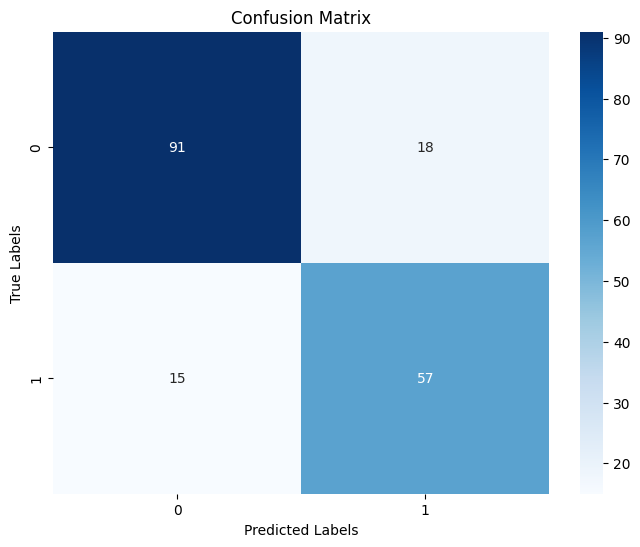

In [ ]:
reload_all()
msa_nas_mlp_metrics.print_metrics()

plotter.plot_confusion_matrix(msa_nas_mlp_metrics.cf_matrix, total_labels=msa_nas_labels, test_labels=y_test)

##### Testing the model on the test set

Len of ttaining loss: [0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354, 0.3350376654807354]
Time taken by the model: 0.1438465118408203


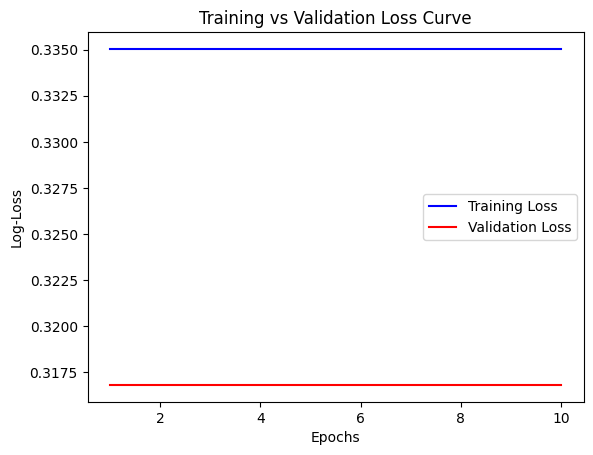

In [116]:
reload_all()

lr = Models.LR()
lr.fit(X_train=X_train, y_train=y_train, epochs=10)

In [ ]:
reload_all()
lr_msa_nas_metrics = lr.evaluate_and_get_metrics(X_test=X_test, y_test=y_test)

In [ ]:
lr_msa_nas_metrics.print_metrics()


Overall Metrics: 

--Test Accuracy: 82.87292817679558
--Macro F1-Score: 0.8245

Class-wise Metrics:
--Precision: 0.7530864197530864
--Recall: 0.847222
--F1-Score: 0.7973856209150327


Time Taken By the model: 0.022866010665893555 seconds 


